In [1]:
import numpy as np

In [2]:
class DualLayer():
    def __init__(self, units = 10):
        self.units = units
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.losses = []
    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.activation(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2
    def backprop(self, x, err):
        m = len(x)
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def init_weights(self, n_features):
        self.w1 = np.ones((n_features, self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.ones((self.units, 1))
        self.b2 = 0
    def training(self, x, y, m):
        z = self.forpass(x)
        a = self.activation(z)
        err = -(y - a)
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        self.w1 -= w1_grad
        self.b1 -= b1_grad
        self.w2 -= w2_grad
        self.b2 -= b2_grad
        return a
    
    def activation(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a
    
    def fit(self, x, y, epochs = 100):
        y = y.reshape(-1,1)
        m = len(x)
        self.init_weights(x.shape[1]) 
        for i in range(epochs):
            a = self.training(x, y, m)
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))
            self.losses.append(loss / m)
    def predict(self, x):
        z = self.forpass(x)
        return z > 0
    def score(self, x, y):
        return np.mean(self.predict(x) == y.reshape(-1, 1))

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
class Learning(DualLayer):
    def __init__(self, units = 10, learning_rate = 0.1):
        self.units = units 
        self.w1 = None 
        self.b1 = None 
        self.w2 = None 
        self.b2 = None 
        self.a1 = None 
        self.lr = learning_rate
        self.w_history = []
        self.losses = []
    def training(self, x, y, m):
        z = self.forpass(x)
        a = self.activation(z)
        err = -(y - a)
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        self.w1 -= self.lr * w1_grad 
        self.b1 -= b1_grad
        self.w2 -= self.lr * w2_grad
        self.b2 -= b2_grad
        return a

    def fit(self, x, y, epochs = 100):
        y = y.reshape(-1,1)
        m = len(x)
        self.init_weights(x.shape[1])
        self.w_history.append([self.w1.copy(), self.w2.copy()])
        for i in range(epochs):
            a = self.training(x, y, m)
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))
            self.losses.append(loss / m)
            self.w_history.append([self.w1.copy(), self.w2.copy()])


In [11]:
learning = Learning(learning_rate=0.1)
learning.fit(X_train_scaled, y_train, epochs = 15000)
print(learning.score(X_test_scaled, y_test))

0.9649122807017544


0.05584163474098459


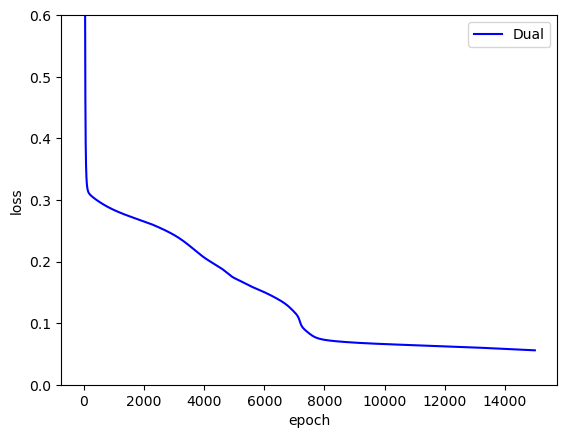

In [12]:
import matplotlib.pyplot as plt

plt.plot(learning.losses, 'b', label = 'Dual')
print(learning.losses[-1])
plt.ylim(0,0.6)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [16]:
X_train.shape

(455, 30)

In [24]:
learning.w_history[0][0][0,0]

1.0

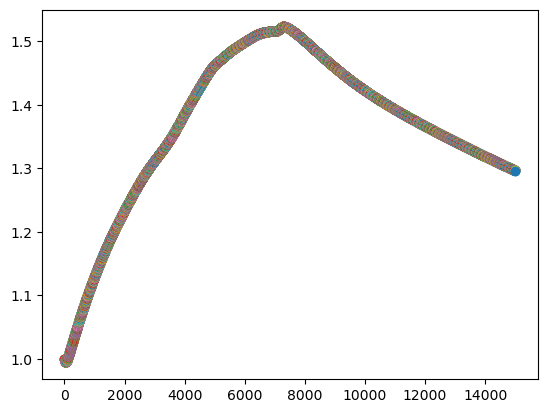

In [25]:
w1 = []
for w in learning.w_history:
    w1.append(w[0])
for i,w in enumerate(w1):
    plt.plot(i,w[0,0],'o')

0.9708560048284048


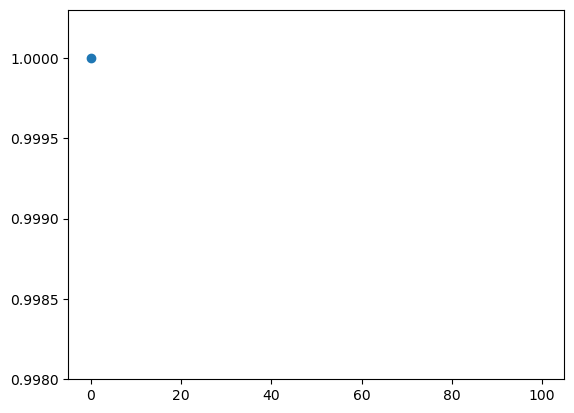

In [37]:
learning = Learning(learning_rate=10)
learning.fit(X_train_scaled, y_train, epochs = 100)

print(learning.w_history[1][0][0,0]) # weight가 처음 업데이트 된 값

plt.ylim(0.998, 1.0003)
w1 = []
for w in learning.w_history:
    w1.append(w[0])
for i,w in enumerate(w1):
    plt.plot(i,w[0,0],'o')

In [49]:
class Validation(DualLayer):
    def __init__(self, units = 10):
        self.units = units 
        self.w1 = None 
        self.b1 = None 
        self.w2 = None 
        self.b2 = None 
        self.a1 = None 
        self.losses = []
        self.val_losses = []
    def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
        y = y.reshape(-1,1)
        y_val = y_val.reshape(-1, 1)
        m = len(x)
        self.init_weights(x.shape[1])
        for i in range(epochs):
            a = self.training(x, y, m)
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))
            self.losses.append(loss / m)
            self.update_val_loss(x_val, y_val)
    def init_weights(self, n_features):
        self.w1 = np.random.normal(0, 2 / np.sqrt(n_features + self.units), (n_features, self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0, 2 / np.sqrt(n_features + self.units), (self.units, 1))
        self.b2 = 0

    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        z = self.forpass(x_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-(y_val * np.log(a) + (1 - y_val) * np.log(1 - a)))
        self.val_losses.append(val_loss / len(x_val))


In [52]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y_train, 
                                            test_size = 0.2, random_state = 0)
validation = Validation()
validation.fit(X_tr, y_tr, epochs = 1000, x_val=X_val, y_val=y_val)
print(validation.score(X_test_scaled, y_test))

0.9736842105263158


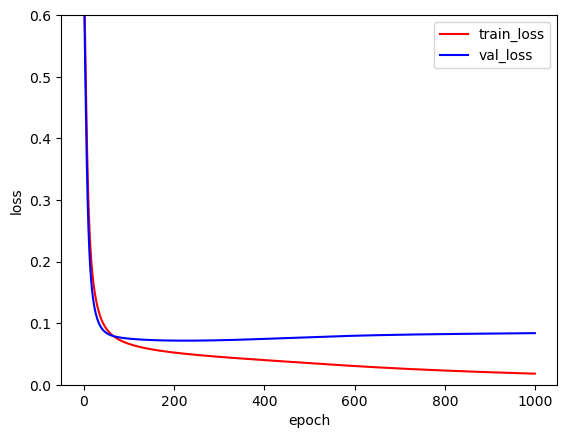

In [53]:
import matplotlib.pyplot as plt
plt.ylim(0, 0.6)
plt.plot(validation.losses, 'r', label='train_loss')
plt.plot(validation.val_losses, 'b', label='val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()


In [67]:
validation = Validation()
validation.fit(X_tr, y_tr, epochs = 100, x_val=X_val, y_val=y_val)
print(validation.score(X_test_scaled, y_test))

0.956140350877193


In [42]:
validation = Validation()
validation.fit(X_tr, y_tr, epochs = 700, x_val=X_val, y_val=y_val)
print(validation.score(X_test_scaled, y_test))

0.9298245614035088


In [43]:
validation = Validation()
validation.fit(X_tr, y_tr, epochs = 600, x_val=X_val, y_val=y_val)
print(validation.score(X_test_scaled, y_test))

0.9473684210526315


In [92]:
arr = np.array([1,2,3,4,5,6,7,8,9,10,11])
def test():
    for i in range(len(arr) // 2 + 1):
        start = 2 * i
        end = 2 * (i + 1)
        x = arr[start:end]
        yield x

In [91]:
for i in test():
    print(i)

[1 2]
[3 4]
[5 6]
[7 8]
[ 9 10]
[11]


In [129]:
class Minibatch(DualLayer):
    def __init__(self, units = 10, learning_rate = 0.1, batch_size = 32):
        super().__init__(units = units)
        self.lr = learning_rate
        self.batch_size = batch_size
        
    def fit(self, x, y, epochs = 100):
        
        self.init_weights(x.shape[1])
        for i in range(epochs):
#             print('### epochs', i + 1)
            loss = 0
            cnt = 0
            for x_batch, y_batch in self.gen_batch(x, y):
                cnt += 1
                
                y_batch = y_batch.reshape(-1, 1)
                m = len(x_batch)
                a = self.training(x_batch, y_batch, m)
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += np.sum(-(y_batch * np.log(a) + (1 - y_batch) * np.log(1 - a)))
            self.losses.append(loss / len(x))


    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size
        if length % self.batch_size:
            bins += 1
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]
    def training(self, x, y, m):
        z = self.forpass(x)
        a = self.activation(z)
        err = -(y - a)
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        self.w1 -= self.lr * w1_grad
        self.b1 -= b1_grad
        self.w2 -= self.lr * w2_grad
        self.b2 -= b2_grad
        return a

In [120]:
X_train_scaled.shape

(455, 30)

In [140]:
minibatch = Minibatch(batch_size=16, learning_rate = 0.1)
minibatch.fit(X_train_scaled, y_train, epochs = 1000)
print(minibatch.score(X_test_scaled, y_test))

0.9736842105263158


In [138]:
minibatch2 = Minibatch(batch_size=32, learning_rate = 0.1)
minibatch2.fit(X_train_scaled, y_train, epochs = 1000)
print(minibatch2.score(X_test_scaled, y_test))

0.9649122807017544


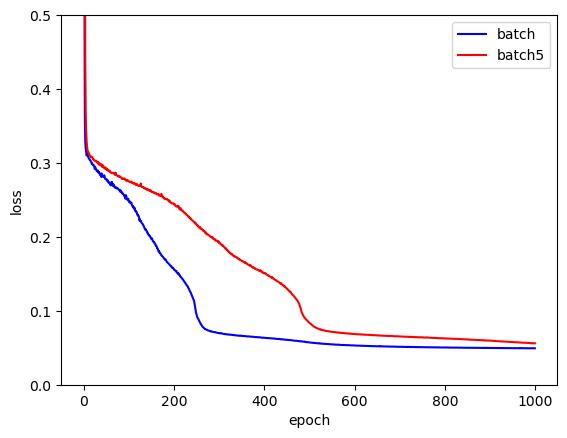

In [142]:
plt.plot(minibatch.losses, 'b', label = 'batch')
plt.plot(minibatch2.losses, 'r', label = 'batch5')
plt.ylim(0,0.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


In [143]:
x = np.arange(30).reshape(10, 3)

In [146]:
w = np.ones((x.shape[1], 10))

In [150]:
z = np.dot(x, w) + np.zeros(10)

In [153]:
z

array([[ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.],
       [12., 12., 12., 12., 12., 12., 12., 12., 12., 12.],
       [21., 21., 21., 21., 21., 21., 21., 21., 21., 21.],
       [30., 30., 30., 30., 30., 30., 30., 30., 30., 30.],
       [39., 39., 39., 39., 39., 39., 39., 39., 39., 39.],
       [48., 48., 48., 48., 48., 48., 48., 48., 48., 48.],
       [57., 57., 57., 57., 57., 57., 57., 57., 57., 57.],
       [66., 66., 66., 66., 66., 66., 66., 66., 66., 66.],
       [75., 75., 75., 75., 75., 75., 75., 75., 75., 75.],
       [84., 84., 84., 84., 84., 84., 84., 84., 84., 84.]])

In [157]:
z * (np.random.uniform(0, 1, z.shape) > 1)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [160]:
class Dropout(DualLayer):
    def __init__(self, units = 10, dropout = 0.5, random_state = None):
        super().__init__(units)
        self.dropout = dropout
        self.random_state = random_state
    def drop(self, z):
        if self.dropout == 1:
            return np.zeros_like(z)
        np.random.seed(self.random_state)
        mask = np.random.uniform(0, 1, z.shape) > self.dropout
        return (mask * z) / (1.0 - self.dropout)

    def training(self, x, y, m):
        z = self.forpass(x)
        # 입력 > 은닉 > z
        # z > 활성화 > a
        # a > 은닉 > z
        # z > 마지막활성화 > a
        z = self.drop(z) # 드롭 아웃 적용
        a = self.activation(z)
        err = -(y - a)
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        self.w1 -= w1_grad
        self.b1 -= b1_grad
        self.w2 -= w2_grad
        self.b2 -= b2_grad
        return a


In [173]:
dual_layer = DualLayer()
dual_layer.fit(X_train_scaled, y_train, epochs = 1000)
print(dual_layer.score(X_test_scaled, y_test))
dropout = Dropout(random_state=None)
dropout.fit(X_train_scaled, y_train, epochs = 1000)
print(dropout.score(X_test_scaled, y_test))

0.956140350877193
0.956140350877193


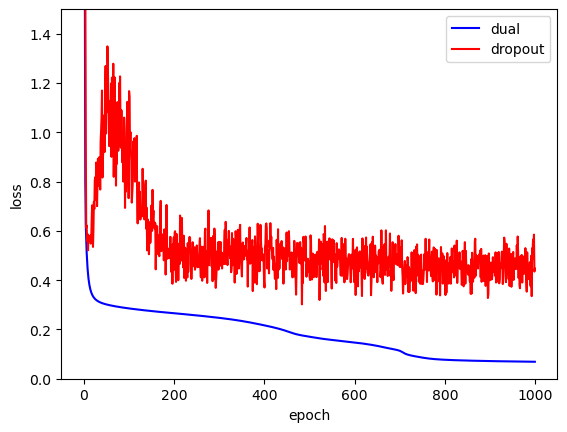

In [174]:
plt.plot(dual_layer.losses, 'b', label = 'dual')
plt.plot(dropout.losses, 'r', label = 'dropout')
plt.ylim(0,1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [175]:
pred1 = dual_layer.predict(X_test_scaled)
pred2 = dropout.predict(X_test_scaled)

In [179]:
pred1.reshape(-1)

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False, False, False,  True, False,
       False, False, False, False,  True,  True, False,  True,  True,
       False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False, False,  True, False,  True,  True,
       False,  True,  True,  True, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
        True, False,  True, False, False, False,  True,  True, False,
        True, False, False,  True,  True,  True,  True,  True, False,
       False, False,  True, False,  True,  True,  True, False, False,
        True, False, False, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
        True, False,  True, False, False,  True])

In [180]:
pred2.reshape(-1)

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False,  True, False,
       False, False, False, False,  True,  True, False,  True,  True,
       False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False, False,  True, False,  True,  True,
       False,  True,  True,  True, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
        True, False,  True, False, False, False,  True,  True, False,
        True, False, False,  True,  True,  True,  True,  True, False,
       False, False,  True, False,  True,  True,  True, False, False,
        True, False, False, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
        True,  True,  True, False, False,  True])

In [191]:
np.hstack([np.arange(0.3, 0, -0.1), np.arange(0.11, 0.5, 0.03) ])

array([0.3 , 0.2 , 0.1 , 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29, 0.32,
       0.35, 0.38, 0.41, 0.44, 0.47, 0.5 ])

In [ ]:
min_loss = 1 

In [199]:
class Early_stop(Validation):
    def __init__(self, units = 10, earlystop = 10):
        super().__init__(units)
        self.minloss = None
        self.earlystop = earlystop

    def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
        y = y.reshape(-1,1)
        y_val = y_val.reshape(-1, 1)
        m = len(x)
        self.init_weights(x.shape[1])
        for i in range(epochs):
            
            a = self.training(x, y, m)
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))
            self.losses.append(loss / m)
            self.update_val_loss(x_val, y_val)
            if i % 10 == 0:
                print(f'### epoch : {i}', end = '\t')
                print(f'val_loss : {self.val_losses[-1]}')
            if i == (self.earlystop - 1):
                self.minloss = min(self.val_losses)
            if i >= self.earlystop:
                if self.minloss < min(self.val_losses[-self.earlystop:]):
                    print('-----------------------------')
                    print(f'EarlyStop : Epochs {i}')
                    break
                else:
                    self.minloss = min(self.val_losses)



In [200]:
early_stop = Early_stop(earlystop = 100)
early_stop.fit(X_tr, y_tr, epochs = 1000, x_val=X_val, y_val=y_val)
# print(early_stop.score(X_test_scaled, y_test))

### epoch : 0	val_loss : 0.5594820067464993
### epoch : 10	val_loss : 0.2655765831089426
### epoch : 20	val_loss : 0.16774594714046637
### epoch : 30	val_loss : 0.12758056946546634
### epoch : 40	val_loss : 0.10431781317037003
### epoch : 50	val_loss : 0.0886970656832768
### epoch : 60	val_loss : 0.08086810430513042
### epoch : 70	val_loss : 0.07719674505055385
### epoch : 80	val_loss : 0.07526614261789877
### epoch : 90	val_loss : 0.07413043357389203
### epoch : 100	val_loss : 0.07338231576300822
### epoch : 110	val_loss : 0.07284187435989857
### epoch : 120	val_loss : 0.07242685580315929
### epoch : 130	val_loss : 0.07209864781337699
### epoch : 140	val_loss : 0.07183870419088605
### epoch : 150	val_loss : 0.07163766018777229
### epoch : 160	val_loss : 0.07149005469373998
### epoch : 170	val_loss : 0.07139176084203132
### epoch : 180	val_loss : 0.0713388576367626
### epoch : 190	val_loss : 0.07132728833681533
### epoch : 200	val_loss : 0.07135289824557221
### epoch : 210	val_loss : 0

In [201]:
print(early_stop.score(X_test_scaled, y_test))

0.9649122807017544


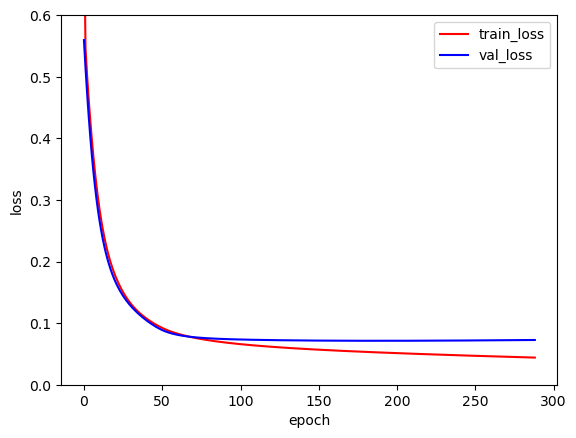

In [202]:
plt.plot(early_stop.losses, 'r', label='train_loss')
plt.plot(early_stop.val_losses, 'b', label='val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0, 0.6)
plt.legend()
plt.show()
